# Learn Linear Regression by Implementing in NumPy
> Explaination of linear regression by implementing it in Python NumPy.

- toc: false 
- badges: true
- comments: true
- author: Adam Orucu
- categories: [machine learning, numpy]
- image: images/cover/linear-regression.png

Following the principle:
> The best way to learn is by doing.

In this post we will learn how linear regression works and implement it at the same time. This is the first post of a series so if you end up learning something usefull don't stop and continue with the next ones.

In [1]:
#collapse-hide
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from IPython.display import Code
%matplotlib inline
import seaborn as sns
sns.set_style('darkgrid')
from sklearn import datasets
from sklearn.model_selection import train_test_split

%load_ext autoreload
%autoreload 2

## About the data

Data that we will be using is the [Boston Housing Dataset](https://www.cs.toronto.edu/~delve/data/boston/bostonDetail.html) which .. 

In [2]:
#collapse-hide
X, y = datasets.load_boston(return_X_y=True)
X = pd.DataFrame(data=X, columns=['CRIM', 'ZN', 'INDUS', 'CHAS', 'NOX', 'RM', 'AGE', 'DIS', 'RAD', 'TAX', 'PTRATIO', 'B', 'LSTAT'])
X_train, X_test, y_train, y_test = train_test_split(X['AGE'].to_numpy().reshape(-1, 1), y, test_size=0.33, random_state=42)

[asd](https://scikit-learn.org/stable/datasets/index.html#boston-dataset)

In [3]:
X.head()

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT
0,0.00632,18.0,2.31,0.0,0.538,6.575,65.2,4.0900,1.0,296.0,15.3,396.90,4.98
1,0.02731,0.0,7.07,0.0,0.469,6.421,78.9,4.9671,2.0,242.0,17.8,396.90,9.14
2,0.02729,0.0,7.07,0.0,0.469,7.185,61.1,4.9671,2.0,242.0,17.8,392.83,4.03
3,0.03237,0.0,2.18,0.0,0.458,6.998,45.8,6.0622,3.0,222.0,18.7,394.63,2.94
4,0.06905,0.0,2.18,0.0,0.458,7.147,54.2,6.0622,3.0,222.0,18.7,396.90,5.33


## Our Goal

In [4]:
from sklearn.linear_model import LinearRegression as skLinReg
clf = skLinReg().fit(X_train, y_train)
pd.DataFrame(data=[clf.predict(X_test)[:5], y_test[:5]], index=['Prediction', 'True'])

,0,1,2,3,4
Prediction,21.133509,27.338643,19.351957,30.380613,20.200315
True,23.600000,32.400000,13.600000,22.800000,16.100000


## Linear Regression

Linear regression is the simplest machine learning algorithm to learn. ... 

In [5]:
#hide_input
Code('''
def predict(self, X):
    X = np.hstack((X, np.ones((X.shape[0], 1), dtype=X.dtype)))
    return X.dot(self.weights)
''', language='py')

def predict(self, X):
    X = np.hstack((X, np.ones((X.shape[0], 1), dtype=X.dtype)))
    return X.dot(self.weights)

learning afdkadjfljasd dskf jadslfj sd

In [6]:
#hide_input
Code('''
def fit(self, X, y, iters=5000, lr=0.0001):
    self.n = X.shape[1]
    self.m = X.shape[0]
    self.weights = np.random.rand(self.n+1,1) if not 'weights' in dir(self) else self.weights
    self.gradient_descent(X, y, iters, lr)
''', language='py')

def fit(self, X, y, iters=5000, lr=0.0001):
    self.n = X.shape[1]
    self.m = X.shape[0]
    self.weights = np.random.rand(self.n+1,1) if not 'weights' in dir(self) else self.weights
    self.gradient_descent(X, y, iters, lr)

### Gradient Descent

Greasdasdf asdf asdf asdf

In [7]:
#hide_input
Code('''
def gradient_descent(self, X, y, iters, lr):
    X = np.hstack((X, np.ones((X.shape[0], 1), dtype=X.dtype)))
    y = np.reshape(y, (len(y),1))
    for i in range(iters):
        gradient = (X.dot(self.weights) - y).transpose().dot(X)
        self.weights = self.weights - (lr * 1/self.m * gradient.transpose())
        self.loss.append(1/(2*self.m) * np.sum(np.square(X.dot(self.weights) - y)))
''', language='py')

def gradient_descent(self, X, y, iters, lr):
    X = np.hstack((X, np.ones((X.shape[0], 1), dtype=X.dtype)))
    y = np.reshape(y, (len(y),1))
    for i in range(iters):
        gradient = (X.dot(self.weights) - y).transpose().dot(X)
        self.weights = self.weights - (lr * 1/self.m * gradient.transpose())
        self.loss.append(1/(2*self.m) * np.sum(np.square(X.dot(self.weights) - y)))

If you'd like to see the entire object you see it by clicking the button below.

In [8]:
#collapse-hide
class LinearRegression:
    def __init__(self):
        self.loss = []
    
    def fit(self, X, y, iters=50000, lr=3e-4):
        self.n = X.shape[1]
        self.m = X.shape[0]
        self.weights = np.random.rand(self.n+1,1) if not 'weights' in dir(self) else self.weights
        self.gradient_descent(X, y, iters, lr)
        
#     def cost(self, X, y):
#         pred = self.predict(X)
#         return 1/len(pred) * (pred - y)**2
    
    def predict(self, X):
        X = np.hstack((X, np.ones((X.shape[0], 1), dtype=X.dtype)))
        return X.dot(self.weights)
    
    def gradient_descent(self, X, y, iters, lr):
        X = np.hstack((X, np.ones((X.shape[0], 1), dtype=X.dtype)))
        y = np.reshape(y, (len(y),1))
        for i in range(iters):
            gradient = (X.dot(self.weights) - y).transpose().dot(X)
            self.weights = self.weights - (lr * 1/self.m * gradient.transpose())
            self.loss.append(1/(2*self.m) * np.sum(np.square(X.dot(self.weights) - y)))

#### Results

In [9]:
#collapse-hide
LinReg = LinearRegression()
LinReg.fit(X_train, y_train)
pd.DataFrame(data=[LinReg.predict(X_test)[:5,0], y_test[:5]], index=['Prediction', 'True'])

,0,1,2,3,4
Prediction,21.313305,25.13514,20.216021,27.008735,20.738537
True,23.600000,32.40000,13.600000,22.800000,16.100000


#### Learning

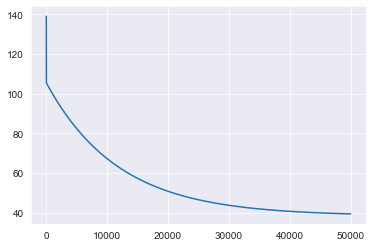

In [10]:
plt.plot(LinReg.loss);plt.show()

##### Comparison

In [11]:
#collapse-hide
from sklearn.metrics import mean_squared_error
print('Our: ', mean_squared_error(LinReg.predict(X_test), y_test),
      '\nSklearns: ', mean_squared_error(clf.predict(X_test), y_test))

Our:  65.40209298303503 
Sklearns:  64.45241584915276


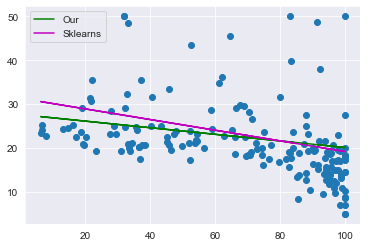

In [12]:
#collapse-hide
LinReg = LinearRegression()
sk = skLinReg()
LinReg.fit(X_train, y_train)
sk.fit(X_train, y_train)

plt.scatter(X_test, y_test)
plt.plot(X_test, LinReg.predict(X_test), 'g')
plt.plot(X_test, sk.predict(X_test), 'm')
plt.legend(['Our', 'Sklearns'])
plt.show()

---

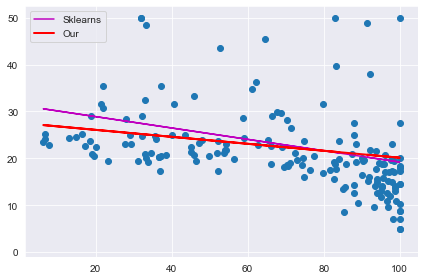

In [13]:
#hide_output
#collapse_hide
from matplotlib import animation
fig, ax = plt.subplots()
fig.set_tight_layout(True)

LinReg2 = LinearRegression()
LinReg2.fit(X_train, y_train, iters=0)
sk = skLinReg()
sk.fit(X_train, y_train)
ax.scatter(X_test, y_test)
ax.plot(X_test, sk.predict(X_test), 'm-')
line, = ax.plot(X_test, np.hstack((X_test, np.ones((X_test.shape[0], 1), dtype=X_test.dtype))).dot(LinReg2.weights), 'r-', linewidth=2)
ax.legend(('Sklearns', 'Our'))

Writer = animation.writers['pillow']
writer = Writer(fps=15, metadata=dict(artist='Me'), bitrate=1800)

def init():
    line.set_data([], [])
    return line,

def animate(i):
    LinReg2.fit(X_train, y_train, iters=250)
    line.set_data(X_test, LinReg2.predict(X_test))
    return line,

anim = animation.FuncAnimation(fig, animate, init_func=init,
                               frames=200, interval=200, repeat_delay=1000, blit=True)

anim.save('gif/linreg.gif', writer=writer)

![](gif/linreg.gif)